Replication of solar_system_nbody.ipynb which uses the tensor core engine with a use of the fortran kernel (using the tensor core engine but optimised for 300x speedup over CuPy instead of 2x)

cupy replicate with only sun having gravity 

In [1]:
import numpy as np
import pygame
from pygame.locals import DOUBLEBUF, OPENGL
from OpenGL.GL import *
from OpenGL.GLU import *
import math
import time

def main():
    """Solar system simulation with Sun-centered gravity and complete planets."""
    # Initialize pygame
    pygame.init()
    display = (1200, 900)
    pygame.display.set_mode(display, DOUBLEBUF | OPENGL | pygame.FULLSCREEN )
    pygame.display.set_caption("Complete Solar System Simulation")
    
    # Set up OpenGL
    glClearColor(0.0, 0.0, 0.1, 1.0)
    glEnable(GL_DEPTH_TEST)
    
    # Font for text display
    font = pygame.font.SysFont("Arial", 18)
    
    # Constants
    G = 1.0  # Gravitational constant
    sun_mass = 1000.0  # Massive sun
    
    # Calculate relative masses (Sun is 1000)
    mercury_mass = sun_mass * (3.301e23 / 1.989e30)  # ≈ 0.000166
    venus_mass = sun_mass * (4.868e24 / 1.989e30)    # ≈ 0.00245
    earth_mass = sun_mass * (5.972e24 / 1.989e30)    # ≈ 0.003
    mars_mass = sun_mass * (6.417e23 / 1.989e30)     # ≈ 0.000323
    jupiter_mass = sun_mass * (1.898e27 / 1.989e30)  # ≈ 0.954
    saturn_mass = sun_mass * (5.683e26 / 1.989e30)   # ≈ 0.286
    uranus_mass = sun_mass * (8.681e25 / 1.989e30)   # ≈ 0.044
    neptune_mass = sun_mass * (1.024e26 / 1.989e30)  # ≈ 0.051
    pluto_mass = sun_mass * (1.303e22 / 1.989e30)    # ≈ 0.0000065
    
    # Define planet data with proper scales
    # Format: (name, mass, distance, initial_angle, size, color)
    planet_data = [
        ("Mercury", mercury_mass, 4.0, 0, 0.02, (0.8, 0.8, 0.8)),
        ("Venus", venus_mass, 7.0, 45, 0.03, (0.9, 0.7, 0.5)),
        ("Earth", earth_mass, 10.0, 90, 0.035, (0.0, 0.5, 1.0)),
        ("Mars", mars_mass, 15.0, 135, 0.025, (1.0, 0.5, 0.0)),
        ("Jupiter", jupiter_mass, 24.0, 180, 0.1, (0.9, 0.7, 0.0)),
        ("Saturn", saturn_mass, 30.0, 225, 0.09, (0.95, 0.85, 0.65)),
        ("Uranus", uranus_mass, 36.0, 270, 0.07, (0.7, 0.85, 0.9)),
        ("Neptune", neptune_mass, 42.0, 315, 0.07, (0.3, 0.4, 0.9)),
        ("Pluto", pluto_mass, 47.0, 10, 0.015, (0.6, 0.6, 0.6))
    ]
    
    # Create bodies
    bodies = []
    
    # Add sun at center
    bodies.append({
        "name": "Sun",
        "mass": sun_mass,  
        "position": np.array([0.0, 0.0, 0.0]),
        "velocity": np.array([0.0, 0.0, 0.0]),
        "size": 0.3,  # Smaller for better scale
        "color": (1.0, 1.0, 0.0)
    })
    
    # Add planets distributed around the Sun
    for name, mass, distance, angle, size, color in planet_data:
        # Calculate orbital velocity - assuming circular orbit
        orbital_speed = math.sqrt(G * sun_mass / distance)
        
        # Convert angle to radians
        angle_rad = math.radians(angle)
        
        # Position based on angle around orbit
        x = distance * math.cos(angle_rad)
        z = distance * math.sin(angle_rad)
        
        bodies.append({
            "name": name,
            "mass": mass,
            "position": np.array([x, 0.0, z]),  # Distribute in the XZ plane
            "velocity": np.array([-orbital_speed * math.sin(angle_rad), 
                                  0.0, 
                                  orbital_speed * math.cos(angle_rad)]),  # Tangential velocity
            "size": size,
            "color": color
        })
    
    # Store trajectories - use lines instead of dots for smoother trails
    max_trail_points = 5000  # Increased for longer trails
    trails = [[] for _ in range(len(bodies))]
    trail_skip = 1  # Don't skip points for dense trails
    
    # Special rendering for Saturn's rings
    def draw_saturn_rings(position, size):
        glPushMatrix()
        glTranslatef(position[0], position[1], position[2])
        
        # Rotate rings to be perpendicular to the orbital plane
        glRotatef(80, 1, 0, 0)  # Slight tilt
        
        # Inner and outer ring radiuses
        inner_radius = size * 1.2
        outer_radius = size * 2.0
        
        # Draw rings - thin disk with gradient
        glBegin(GL_QUAD_STRIP)
        segments = 64
        for i in range(segments + 1):
            angle = 2.0 * math.pi * i / segments
            x = math.cos(angle)
            z = math.sin(angle)
            
            # Inner ring - slightly transparent
            glColor4f(0.9, 0.8, 0.6, 0.7)
            glVertex3f(x * inner_radius, 0, z * inner_radius)
            
            # Outer ring - more transparent
            glColor4f(0.9, 0.8, 0.6, 0.4)
            glVertex3f(x * outer_radius, 0, z * outer_radius)
        glEnd()
        
        glPopMatrix()
    
    # Camera settings
    dist = 60.0  # Larger to see all planets
    theta = 45.0
    phi = 30.0
    
    # Main loop parameters
    dt = 0.0005  # Small time step for stability
    steps_per_frame = 60
    clock = pygame.time.Clock()
    paused = False
    show_trails = True
    show_grid = True
    show_labels = True
    follow_planet = None  # Index of planet to follow, None for free camera
    
    # Create a separate surface for text overlay
    text_surface = pygame.Surface((400, 350), pygame.SRCALPHA)
    
    running = True
    frame = 0
    
    # Simple function to calculate Sun-only gravity
    def calculate_sun_gravity(positions, velocities, masses, dt):
        for i in range(1, len(positions)):  # Skip sun
            # Vector from planet to sun
            dx = positions[0][0] - positions[i][0]
            dy = positions[0][1] - positions[i][1]
            dz = positions[0][2] - positions[i][2]
            
            # Distance squared with small softening factor
            r_squared = dx*dx + dy*dy + dz*dz + 1e-4
            
            # Force magnitude (F = G*m1*m2/r^2)
            force_mag = G * masses[0] * masses[i] / r_squared
            
            # Unit vector component
            inv_r = 1.0 / math.sqrt(r_squared)
            
            # Force components
            fx = force_mag * dx * inv_r
            fy = force_mag * dy * inv_r
            fz = force_mag * dz * inv_r
            
            # Acceleration (a = F/m)
            ax = fx / masses[i]
            ay = fy / masses[i]
            az = fz / masses[i]
            
            # Update velocity (half step in leapfrog integration)
            velocities[i][0] += ax * dt
            velocities[i][1] += ay * dt
            velocities[i][2] += az * dt
            
            # Update position
            positions[i][0] += velocities[i][0] * dt
            positions[i][1] += velocities[i][1] * dt
            positions[i][2] += velocities[i][2] * dt
    
    while running:
        frame += 1
        
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    running = False
                elif event.key == pygame.K_SPACE:
                    paused = not paused
                elif event.key == pygame.K_UP:
                    steps_per_frame = min(steps_per_frame * 2, 100)
                elif event.key == pygame.K_DOWN:
                    steps_per_frame = max(1, steps_per_frame // 2)
                elif event.key == pygame.K_t:
                    show_trails = not show_trails
                elif event.key == pygame.K_g:
                    show_grid = not show_grid
                elif event.key == pygame.K_l:
                    show_labels = not show_labels
                # Number keys to follow planets (0 for free camera)
                elif event.key >= pygame.K_0 and event.key <= pygame.K_9:
                    planet_idx = event.key - pygame.K_0
                    if planet_idx == 0 or planet_idx >= len(bodies):
                        follow_planet = None  # Free camera
                    else:
                        follow_planet = planet_idx
                        print(f"Following {bodies[planet_idx]['name']}")
            elif event.type == pygame.MOUSEMOTION:
                if pygame.mouse.get_pressed()[0]:
                    dx, dy = event.rel
                    theta += dx * 0.5
                    phi = max(-85, min(85, phi - dy * 0.5))
            elif event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 4:  # Scroll up
                    dist = max(5, dist - 2)
                elif event.button == 5:  # Scroll down
                    dist = min(100, dist + 2)
        
        # Extract arrays for calculation
        positions = np.array([body["position"] for body in bodies])
        velocities = np.array([body["velocity"] for body in bodies])
        masses = np.array([body["mass"] for body in bodies])
        
        # Update simulation
        if not paused:
            for step in range(steps_per_frame):
                # Calculate gravity with Sun-only model
                calculate_sun_gravity(positions, velocities, masses, dt)
            
            # Update body data
            for i, body in enumerate(bodies):
                body["position"] = positions[i]
                body["velocity"] = velocities[i]
            
            # Add to trails (every few frames to save memory)
            if frame % 2 == 0:  # More frequent updates for smoother trails
                for i in range(len(bodies)):
                    if i > 0:  # Skip sun
                        # Create a deep copy to avoid reference issues
                        pos_copy = np.array([
                            positions[i][0],
                            positions[i][1],
                            positions[i][2]
                        ])
                        trails[i].append(pos_copy)
                
                # Keep trails a reasonable length
                for i in range(len(bodies)):
                    while len(trails[i]) > max_trail_points:
                        trails[i].pop(0)
        
        # Render 3D scene
        glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
        
        # Set up projection
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        gluPerspective(45, (display[0]/display[1]), 0.1, 200.0)
        
        # Set up camera
        glMatrixMode(GL_MODELVIEW)
        glLoadIdentity()
        
        # Camera positioning
        if follow_planet is not None:
            # Follow a specific planet
            target_pos = bodies[follow_planet]["position"]
            
            # Position camera behind and slightly above the planet
            offset_x = -5 * math.cos(math.radians(theta))
            offset_y = 2
            offset_z = -5 * math.sin(math.radians(theta))
            
            camera_pos = target_pos + np.array([offset_x, offset_y, offset_z])
            
            gluLookAt(
                camera_pos[0], camera_pos[1], camera_pos[2],
                target_pos[0], target_pos[1], target_pos[2],
                0, 1, 0
            )
        else:
            # Free camera - standard spherical coordinates
            x = dist * math.cos(math.radians(phi)) * math.cos(math.radians(theta))
            y = dist * math.sin(math.radians(phi))
            z = dist * math.cos(math.radians(phi)) * math.sin(math.radians(theta))
            
            gluLookAt(x, y, z, 0, 0, 0, 0, 1, 0)
        
        # Enable blending for transparency
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        
        # Draw reference grid
        if show_grid:
            draw_grid(50, 5)  # Larger grid for full solar system
        
        # Draw trails first for better depth perception
        if show_trails:
            glLineWidth(1.5)  # Thicker lines for visibility
            
            for i, trail in enumerate(trails):
                if i > 0 and len(trail) > 1:  # Skip sun, need at least 2 points
                    color = bodies[i]["color"]
                    
                    # Draw each trail segment with gradient alpha
                    glBegin(GL_LINE_STRIP)
                    
                    for j in range(0, len(trail), trail_skip):
                        # More recent points are more opaque
                        alpha = 0.3 * (j / len(trail))
                        glColor4f(color[0], color[1], color[2], alpha)
                        pos = trail[j]
                        glVertex3f(pos[0], pos[1], pos[2])
                    
                    glEnd()
            
            glLineWidth(1.0)
        
        # Draw all celestial bodies
        for i, body in enumerate(bodies):
            pos = body["position"]
            color = body["color"]
            size = body["size"]
            
            glPushMatrix()
            glTranslatef(pos[0], pos[1], pos[2])
            
            # Draw the celestial body
            glColor3f(*color)
            
            # Regular sphere for most bodies
            sphere = gluNewQuadric()
            gluQuadricTexture(sphere, GL_TRUE)
            gluSphere(sphere, size, 32, 32)  # Higher resolution
            gluDeleteQuadric(sphere)
            
            glPopMatrix()
            
            # Special case for Saturn - draw rings
            if i > 0 and body["name"] == "Saturn":
                draw_saturn_rings(pos, size)
            
            # Draw name labels if enabled
            if show_labels:
                # Project 3D position to screen coordinates
                modelview = glGetDoublev(GL_MODELVIEW_MATRIX)
                projection = glGetDoublev(GL_PROJECTION_MATRIX)
                viewport = glGetIntegerv(GL_VIEWPORT)
                
                screen_x, screen_y, screen_z = gluProject(
                    pos[0], pos[1] + size + 0.2, pos[2],
                    modelview, projection, viewport
                )
                
                # Only render if in front of camera (positive z)
                if screen_z < 1.0:
                    # Create label surface
                    label = font.render(body["name"], True, (255, 255, 255))
                    label_pos = (int(screen_x - label.get_width() // 2), 
                                int(viewport[3] - screen_y - label.get_height() // 2))
                    
                    # Blit directly to screen
                    screen = pygame.display.get_surface()
                    screen.blit(label, label_pos)
        
        # Render text overlay
        text_surface.fill((0, 0, 0, 128))  # Semi-transparent background
        
        # Calculate planet info
        planet_info = []
        for i in range(1, len(bodies)):
            body = bodies[i]
            dist_to_sun = np.linalg.norm(body["position"] - bodies[0]["position"])
            velocity = np.linalg.norm(body["velocity"])
            planet_info.append((body["name"], dist_to_sun, velocity))
        
        # Sort by distance
        planet_info.sort(key=lambda x: x[1])
        
        # Draw text info
        lines = [
            f"Complete Solar System Simulation",
            f"Steps per frame: {steps_per_frame} ({steps_per_frame * dt:.5f} time units/frame)",
            f"{'PAUSED' if paused else 'RUNNING'}",
            f"Camera: {'Following ' + bodies[follow_planet]['name'] if follow_planet else 'Free View'}",
            "",
            "Planet information:",
        ]
        
        # Add planet info
        for name, distance, velocity in planet_info:
            lines.append(f"  {name}: dist={distance:.2f}, vel={velocity:.2f}")
        
        # Add controls
        lines.extend([
            "",
            "Controls:",
            "Space: Pause/Resume",
            "T: Toggle Trails",
            "G: Toggle Grid",
            "L: Toggle Labels",
            "1-9: Follow planets (0: Free Camera)",
            "Up/Down: Speed × or ÷ 2",
            "Mouse Drag: Rotate View",
            "Scroll: Zoom In/Out"
        ])
        
        y = 10
        for line in lines:
            text = font.render(line, True, (255, 255, 255))
            text_surface.blit(text, (10, y))
            y += 20
        
        # Blit text surface
        screen = pygame.display.get_surface()
        screen.blit(text_surface, (10, 10))
        
        pygame.display.flip()
        clock.tick(60)
    
    # Cleanup
    pygame.quit()

def draw_grid(size, step):
    """Draw a reference grid on the XZ plane."""
    glBegin(GL_LINES)
    
    # Main grid
    glColor4f(0.2, 0.2, 0.2, 0.5)  # Dark gray with transparency
    
    for i in range(-size, size+1, step):
        # Lines along X axis
        glVertex3f(-size, 0, i)
        glVertex3f(size, 0, i)
        
        # Lines along Z axis
        glVertex3f(i, 0, -size)
        glVertex3f(i, 0, size)
    
    glEnd()

if __name__ == "__main__":
    main()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Interesting variation
not just the sun has gravity; more interesting orbits (not real still)

In [2]:
import numpy as np
import cupy as cp
import ctypes
import pygame
from pygame.locals import DOUBLEBUF, OPENGL
from OpenGL.GL import *
from OpenGL.GLU import *
import math
import time

def main():
    """Complete solar system with all planets and enhanced trails."""
    # Initialize pygame
    pygame.init()
    display = (1200, 900)
    pygame.display.set_mode(display, DOUBLEBUF | OPENGL | pygame.FULLSCREEN)
    pygame.display.set_caption("Solar System Simulation - Enhanced Edition")
    
    # Set up OpenGL
    glClearColor(0.0, 0.0, 0.1, 1.0)
    glEnable(GL_DEPTH_TEST)
    
    # Font for text display
    font = pygame.font.SysFont("Arial", 18)
    
    # Load Fortran library
    print("Loading library...")
    try:
        lib = ctypes.CDLL('./nbody_tensor6.so')
        lib.init_nbody()
        print("Library loaded successfully")
    except Exception as e:
        print(f"Error loading library: {e}")
        pygame.quit()
        return
    
    # Set up function signatures
    lib.leapfrog_step.argtypes = [
        ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, 
        ctypes.c_void_p, ctypes.c_int, ctypes.c_double
    ]
    
    # Initialize solar system
    G = 1.0  # Gravitational constant
    sun_mass = 1000.0  # Very massive sun
    
    # Calculate relative masses (Sun is 1000)
    mercury_mass = sun_mass * (3.301e23 / 1.989e30)  # ≈ 0.000166
    venus_mass = sun_mass * (4.868e24 / 1.989e30)    # ≈ 0.00245
    earth_mass = sun_mass * (5.972e24 / 1.989e30)    # ≈ 0.003
    mars_mass = sun_mass * (6.417e23 / 1.989e30)     # ≈ 0.000323
    jupiter_mass = sun_mass * (1.898e27 / 1.989e30)  # ≈ 0.954
    saturn_mass = sun_mass * (5.683e26 / 1.989e30)   # ≈ 0.286
    uranus_mass = sun_mass * (8.681e25 / 1.989e30)   # ≈ 0.044
    neptune_mass = sun_mass * (1.024e26 / 1.989e30)  # ≈ 0.051
    pluto_mass = sun_mass * (1.303e22 / 1.989e30)    # ≈ 0.0000065

    # Define planet data with ALL planets
    # Format: (name, mass, distance, initial_angle, size, color)
    planet_data = [
        ("Mercury", mercury_mass, 4.0, 0, 0.015, (0.8, 0.8, 0.8)),
        ("Venus", venus_mass, 7.0, 72, 0.02, (0.9, 0.7, 0.5)),     # 72 degrees around orbit
        ("Earth", earth_mass, 10.0, 144, 0.025, (0.0, 0.5, 1.0)),  # 144 degrees around orbit
        ("Mars", mars_mass, 15.0, 216, 0.02, (1.0, 0.5, 0.0)),     # 216 degrees around orbit
        ("Jupiter", jupiter_mass, 22.0, 288, 0.04, (0.9, 0.7, 0.0)), # 288 degrees around orbit
        ("Saturn", saturn_mass, 30.0, 45, 0.035, (0.95, 0.85, 0.65)),
        ("Uranus", uranus_mass, 36.0, 120, 0.03, (0.7, 0.85, 0.9)),
        ("Neptune", neptune_mass, 42.0, 180, 0.03, (0.3, 0.4, 0.9)),
        ("Pluto", pluto_mass, 47.0, 240, 0.01, (0.6, 0.6, 0.6))
    ]
    
    # Create bodies
    bodies = []
    
    # Add sun with more reasonable visual size
    bodies.append({
        "name": "Sun",
        "mass": sun_mass,  # Keep mass high for proper gravity
        "position": np.array([0.0, 0.0, 0.0]),
        "velocity": np.array([0.0, 0.0, 0.0]),
        "size": 0.3,  # Reduced size
        "color": (1.0, 1.0, 0.0)
    })
    
    # When creating the planets:
    for name, mass, distance, angle, size, color in planet_data:
        # Calculate orbital velocity
        orbital_speed = math.sqrt(G * sun_mass / distance)
        
        # Convert angle to radians
        angle_rad = math.radians(angle)
        
        # Position based on angle around orbit
        x = distance * math.cos(angle_rad)
        z = distance * math.sin(angle_rad)
        
        bodies.append({
            "name": name,
            "mass": mass,
            "position": np.array([x, 0.0, z]),  # Distribute in the XZ plane
            "velocity": np.array([-orbital_speed * math.sin(angle_rad), 
                                0.0, 
                                orbital_speed * math.cos(angle_rad)]),  # Tangential velocity
            "size": size,
            "color": color
        })
    
    # Create arrays for Fortran
    positions = cp.array([body["position"] for body in bodies], dtype=cp.float64)
    velocities = cp.array([body["velocity"] for body in bodies], dtype=cp.float64)
    masses = cp.array([body["mass"] for body in bodies], dtype=cp.float64)
    
    # Convert to Fortran order
    positions_f = cp.asfortranarray(positions)
    velocities_f = cp.asfortranarray(velocities)
    forces_f = cp.zeros((len(bodies), 3), dtype=cp.float64, order='F')
    
    # Store trajectories
    trails = [[] for _ in range(len(bodies))]
    max_trail_length = 300  # Longer trails for better visualization
    
    # Camera settings
    dist = 60.0  # Increased to see all planets
    theta = 45.0  # Angle around y-axis
    phi = 30.0    # Angle from xz-plane
    
    # Orbit plane restriction
    restrict_to_plane = False  # Start with plane restriction OFF
    orbit_plane_damping = 0.95  # How strongly to force orbits to XZ plane
    
    # Main loop parameters
    dt = 0.0001  # Very small time step for stability
    steps_per_frame = 60  # More steps for visible movement
    clock = pygame.time.Clock()
    paused = False
    show_trails = True
    show_grid = True
    show_labels = True
    follow_planet = None  # Index of planet to follow, None for free camera
    
    # Create a separate surface for text overlay
    text_surface = pygame.Surface((400, 420), pygame.SRCALPHA)
    
    running = True
    frame = 0
    while running:
        frame += 1
        
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    running = False
                elif event.key == pygame.K_SPACE:
                    paused = not paused
                elif event.key == pygame.K_UP:
                    steps_per_frame = min(steps_per_frame * 2, 100)
                elif event.key == pygame.K_DOWN:
                    steps_per_frame = max(1, steps_per_frame // 2)
                elif event.key == pygame.K_t:
                    show_trails = not show_trails
                elif event.key == pygame.K_g:
                    show_grid = not show_grid
                elif event.key == pygame.K_l:
                    show_labels = not show_labels
                elif event.key == pygame.K_p:
                    restrict_to_plane = not restrict_to_plane
                    print(f"Plane restriction: {'ON' if restrict_to_plane else 'OFF'}")
                # Number keys to follow planets (0 for free camera)
                elif event.key >= pygame.K_0 and event.key <= pygame.K_9:
                    planet_idx = event.key - pygame.K_0
                    if planet_idx == 0 or planet_idx >= len(bodies):
                        follow_planet = None  # Free camera
                    else:
                        follow_planet = planet_idx
                        print(f"Following {bodies[planet_idx]['name']}")
            elif event.type == pygame.MOUSEMOTION:
                if pygame.mouse.get_pressed()[0]:
                    dx, dy = event.rel
                    theta += dx * 0.5
                    phi = max(-85, min(85, phi - dy * 0.5))
            elif event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 4:  # Scroll up
                    dist = max(10, dist - 2)
                elif event.button == 5:  # Scroll down
                    dist = min(100, dist + 2)
        
        # Update simulation
        if not paused:
            for step in range(steps_per_frame):
                # Save original sun position and velocity
                sun_pos = positions_f[0].copy()
                sun_vel = velocities_f[0].copy()
                
                # Run simulation step
                lib.leapfrog_step(
                    ctypes.c_void_p(positions_f.data.ptr),
                    ctypes.c_void_p(velocities_f.data.ptr),
                    ctypes.c_void_p(masses.data.ptr),
                    ctypes.c_void_p(forces_f.data.ptr),
                    ctypes.c_int(len(bodies)),
                    ctypes.c_double(dt)
                )
                
                # Force sun to stay fixed at origin
                positions_f[0] = sun_pos
                velocities_f[0] = sun_vel
                
                # Apply orbital plane restriction if enabled
                if restrict_to_plane:
                    for i in range(1, len(bodies)):  # Skip sun
                        # Gradually force planets back to XZ plane by damping Y component
                        positions_f[i][1] *= orbit_plane_damping
                        velocities_f[i][1] *= orbit_plane_damping
            
            # Copy back to Python order
            positions = cp.array(positions_f)
            velocities = cp.array(velocities_f)
            
            # Add to trails (every few frames to save memory)
            if frame % 2 == 0:  # More frequent updates for smoother trails
                for i in range(len(bodies)):
                    if i > 0:  # Skip sun
                        # Create a deep copy to avoid reference issues
                        pos_copy = np.array([
                            positions[i].get()[0],
                            positions[i].get()[1],
                            positions[i].get()[2]
                        ])
                        trails[i].append(pos_copy)
                
                # Keep trails a reasonable length
                for i in range(len(bodies)):
                    while len(trails[i]) > max_trail_length:
                        trails[i].pop(0)
        
        # Render 3D scene
        glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
        
        # Set up projection
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        gluPerspective(45, (display[0]/display[1]), 0.1, 200.0)
        
        # Set up camera
        glMatrixMode(GL_MODELVIEW)
        glLoadIdentity()
        
        # Camera positioning
        if follow_planet is not None:
            # Follow a specific planet
            target_pos = positions[follow_planet].get()
            
            # Position camera behind and slightly above the planet
            offset_x = -5 * math.cos(math.radians(theta))
            offset_y = 2
            offset_z = -5 * math.sin(math.radians(theta))
            
            camera_pos = target_pos + np.array([offset_x, offset_y, offset_z])
            
            gluLookAt(
                camera_pos[0], camera_pos[1], camera_pos[2],
                target_pos[0], target_pos[1], target_pos[2],
                0, 1, 0
            )
        else:
            # Free camera - standard spherical coordinates
            x = dist * math.cos(math.radians(phi)) * math.cos(math.radians(theta))
            y = dist * math.sin(math.radians(phi))
            z = dist * math.cos(math.radians(phi)) * math.sin(math.radians(theta))
            
            gluLookAt(x, y, z, 0, 0, 0, 0, 1, 0)
        
        # Enable blending for transparency
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        
        # Draw reference grid
        if show_grid:
            draw_grid(50, 5)  # Larger grid for complete solar system
        
        # Draw trails first for better depth perception
        if show_trails:
            glLineWidth(1.5)  # Thicker lines for visibility
            
            for i, trail in enumerate(trails):
                if i > 0 and len(trail) > 1:  # Skip sun, need at least 2 points
                    color = bodies[i]["color"]
                    
                    # Draw each trail segment with gradient alpha
                    glBegin(GL_LINE_STRIP)
                    
                    for j in range(len(trail)):
                        # More recent points are more opaque
                        alpha = 0.3 * (j / len(trail))
                        glColor4f(color[0], color[1], color[2], alpha)
                        pos = trail[j]
                        glVertex3f(pos[0], pos[1], pos[2])
                    
                    glEnd()
            
            glLineWidth(1.0)
                
        # Draw all bodies
        for i, body in enumerate(bodies):
            pos = positions[i].get()
            color = body["color"]
            size = body["size"]
            
            glPushMatrix()
            glTranslatef(pos[0], pos[1], pos[2])
            
            # Draw the celestial body
            glColor3f(*color)
            sphere = gluNewQuadric()
            gluSphere(sphere, size, 20, 20)
            gluDeleteQuadric(sphere)
            
            glPopMatrix()
            
            # Draw name labels if enabled
            if show_labels:
                # Project 3D position to screen coordinates
                modelview = glGetDoublev(GL_MODELVIEW_MATRIX)
                projection = glGetDoublev(GL_PROJECTION_MATRIX)
                viewport = glGetIntegerv(GL_VIEWPORT)
                
                screen_x, screen_y, screen_z = gluProject(
                    pos[0], pos[1] + size + 0.2, pos[2],
                    modelview, projection, viewport
                )
                
                # Only render if in front of camera (positive z)
                if screen_z < 1.0:
                    # Create label surface
                    label = font.render(body["name"], True, (255, 255, 255))
                    label_pos = (int(screen_x - label.get_width() // 2), 
                                int(viewport[3] - screen_y - label.get_height() // 2))
                    
                    # Blit directly to screen
                    screen = pygame.display.get_surface()
                    screen.blit(label, label_pos)
        
        # Render text overlay
        text_surface.fill((0, 0, 0, 128))  # Semi-transparent background
        
        # Calculate planet distances from sun
        distances = []
        for i in range(1, len(bodies)):
            planet_pos = positions[i].get()
            dist_to_sun = np.linalg.norm(planet_pos)
            distances.append((bodies[i]["name"], dist_to_sun))
        
        # Sort by distance
        distances.sort(key=lambda x: x[1])
        
        # Draw text info
        lines = [
            f"Camera: dist={dist:.1f}, theta={theta:.1f}°, phi={phi:.1f}°",
            f"Steps per frame: {steps_per_frame}",
            f"{'PAUSED' if paused else 'RUNNING'}",
            f"Plane restriction: {'ON' if restrict_to_plane else 'OFF'}",
            f"Camera: {'Following ' + bodies[follow_planet]['name'] if follow_planet else 'Free View'}",
            "",
            "Planet distances from Sun:",
        ]
        
        # Add planet distances
        for name, distance in distances:
            lines.append(f"  {name}: {distance:.2f}")
        
        # Add controls
        lines.extend([
            "",
            "Controls:",
            "Space: Pause/Resume",
            "T: Toggle Trails",
            "G: Toggle Grid",
            "L: Toggle Labels",
            "P: Toggle Plane Restriction",
            "1-9: Follow planets (0: Free Camera)",
            "Up/Down: Speed × or ÷ 2",
            "Mouse Drag: Rotate View",
            "Scroll: Zoom In/Out"
        ])
        
        y = 10
        for line in lines:
            text = font.render(line, True, (255, 255, 255))
            text_surface.blit(text, (10, y))
            y += 20
        
        # Blit text surface
        screen = pygame.display.get_surface()
        screen.blit(text_surface, (10, 10))
        
        pygame.display.flip()
        clock.tick(60)
    
    # Cleanup
    lib.cleanup_nbody()
    pygame.quit()

def draw_grid(size, step):
    """Draw a reference grid on the XZ plane."""
    glBegin(GL_LINES)
    
    # Main grid
    glColor4f(0.2, 0.2, 0.2, 0.5)  # Dark gray with transparency
    
    for i in range(-size, size+1, step):
        # Lines along X axis
        glVertex3f(-size, 0, i)
        glVertex3f(size, 0, i)
        
        # Lines along Z axis
        glVertex3f(i, 0, -size)
        glVertex3f(i, 0, size)
    
    glEnd()

if __name__ == "__main__":
    main()

Loading library...


: 


=== RUNNING COMPARISON TEST ===
Running CuPy simulation...
Step 0: Position[1] = [0.99995 0.01    0.     ]
Step 100: Position[1] = [0.53128643 0.84624675 0.        ]
Step 200: Position[1] = [-0.42481164  0.89377515  0.        ]
Step 300: Position[1] = [-0.95826873  0.10067941  0.        ]
Step 400: Position[1] = [-0.54564382 -0.7613437   0.        ]
Step 500: Position[1] = [ 0.40719819 -0.85089336  0.        ]
Step 600: Position[1] = [ 0.98869597 -0.08893986  0.        ]
Step 700: Position[1] = [0.6600286  0.81169337 0.        ]
Step 800: Position[1] = [-0.27588162  1.01409544  0.        ]
Step 900: Position[1] = [-0.93327562  0.32001608  0.        ]
CuPy simulation completed in 0.620 seconds

Loading Fortran nbody library...
Initializing CUDA resources...
 N-body Tensor Core simulation initialized with CUDA streams
Running Fortran simulation...
Step 0: Position[1] = [1.   0.01 0.  ], Velocity[1] = [-0.049995    9.99950005  0.        ]
Step 100: Position[1] = [0.53713181 0.84718192 0.

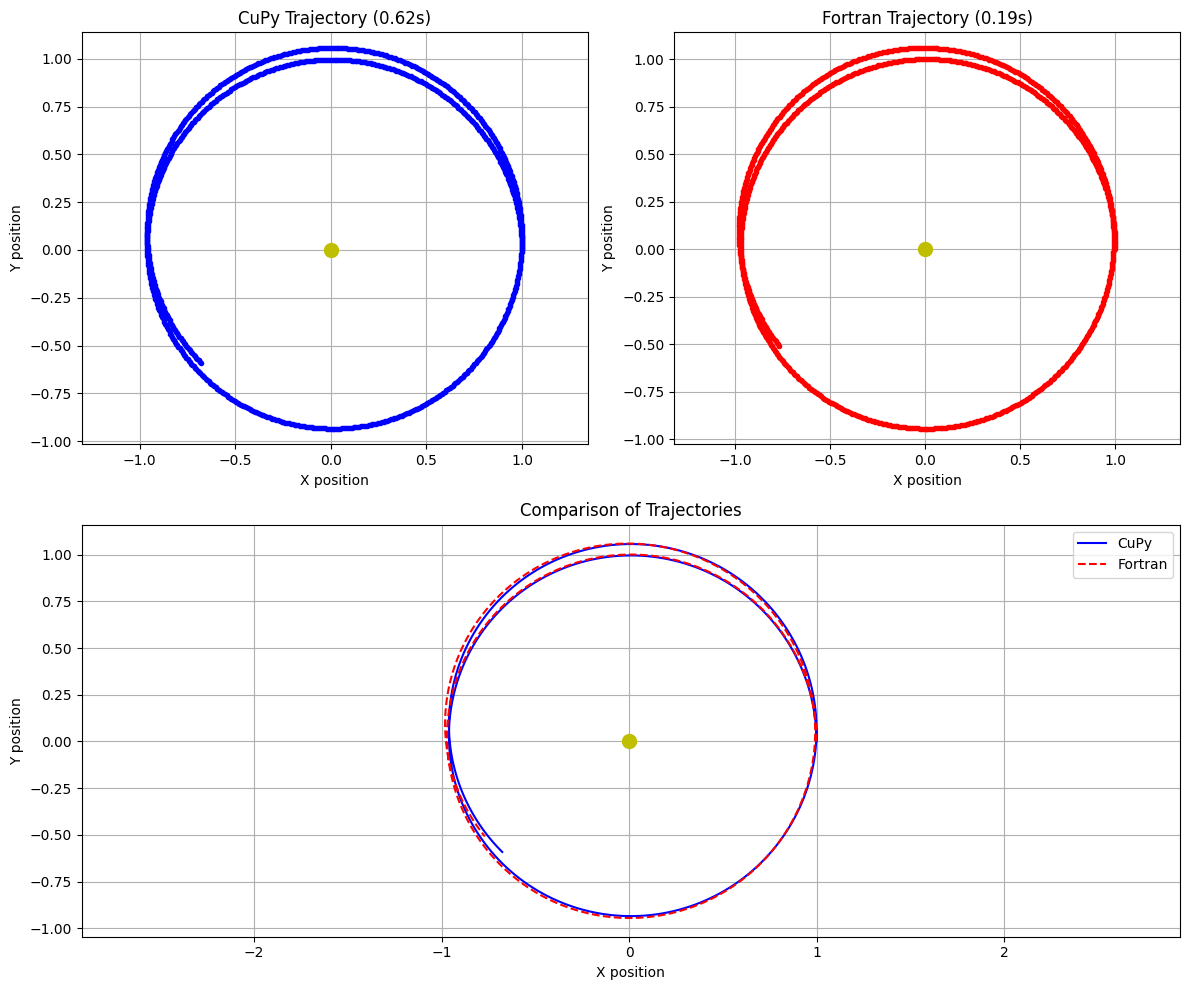

Maximum deviation between trajectories: 0.0992740815261079


In [13]:
import numpy as np
import cupy as cp
import ctypes
import matplotlib.pyplot as plt
import time

class CupyNBodySimulator:
    """N-body simulation using CuPy for comparison."""
    
    def __init__(self):
        # Constants - using G=1 to match Fortran kernel
        self.G = 1.0
        self.softening = 1.0e-4
        
        # Particles
        self.positions = None
        self.velocities = None
        self.masses = None
        self.forces = None
        self.num_particles = 0
    
    def init_particles(self, positions, velocities, masses):
        """Initialize particles with given arrays."""
        self.positions = cp.asarray(positions, dtype=cp.float64)
        self.velocities = cp.asarray(velocities, dtype=cp.float64)
        self.masses = cp.asarray(masses, dtype=cp.float64)
        self.num_particles = len(masses)
        self.forces = cp.zeros_like(self.positions)
    
    def calculate_forces(self):
        """Calculate gravitational forces between all particles."""
        # Reset forces
        self.forces.fill(0)
        
        # Calculate forces between each pair of particles
        for i in range(self.num_particles):
            for j in range(self.num_particles):
                if i != j:
                    # Vector from i to j
                    r = self.positions[j] - self.positions[i]
                    
                    # Distance squared with softening
                    r_squared = cp.sum(r**2) + self.softening**2
                    
                    # Magnitude of force (G * m_i * m_j / r^2)
                    f_mag = self.G * self.masses[i] * self.masses[j] / r_squared
                    
                    # Force direction (unit vector)
                    r_norm = cp.sqrt(r_squared)
                    f_dir = r / r_norm
                    
                    # Add force contribution to particle i
                    self.forces[i] += f_mag * f_dir
    
    def leapfrog_step(self, dt):
        """Leapfrog integration step."""
        # First half-step velocity update
        self.velocities += 0.5 * dt * self.forces / self.masses[:, cp.newaxis]
        
        # Full position update
        self.positions += dt * self.velocities
        
        # Recalculate forces with new positions
        self.calculate_forces()
        
        # Second half-step velocity update
        self.velocities += 0.5 * dt * self.forces / self.masses[:, cp.newaxis]
    
    def run_simulation(self, steps, dt):
        """Run simulation for given number of steps."""
        # Calculate initial forces
        self.calculate_forces()
        
        # Store trajectory
        all_positions = [self.positions.get().copy()]
        
        # Run integration
        for step in range(steps):
            self.leapfrog_step(dt)
            all_positions.append(self.positions.get().copy())
            
            if step % 100 == 0:
                print(f"Step {step}: Position[1] = {self.positions[1]}")
        
        return np.array(all_positions)

def run_comparison_test():
    """Run both Fortran and CuPy implementations for comparison."""
    print("\n=== RUNNING COMPARISON TEST ===")
    # Parameters
    dt = 0.001
    steps = 1000
    
    # ------------------------------------
    # CuPy implementation
    # ------------------------------------
    cupy_sim = CupyNBodySimulator()
    
    # Initialize with same values
    positions = np.array([
        [0.0, 0.0, 0.0],  # Sun at origin
        [1.0, 0.0, 0.0]   # Planet at (1,0,0)
    ])
    
    # Orbital velocity
    v_orbit = np.sqrt(1.0 * 100.0 / 1.0)  # = 10.0
    
    velocities = np.array([
        [0.0, 0.0, 0.0],     # Sun stationary
        [0.0, v_orbit, 0.0]  # Planet with orbital velocity
    ])
    
    masses = np.array([100.0, 1.0])  # 100:1 mass ratio
    
    # Initialize particles
    cupy_sim.init_particles(positions, velocities, masses)
    
    # Run CuPy simulation
    print("Running CuPy simulation...")
    start_time = time.time()
    cupy_positions = cupy_sim.run_simulation(steps, dt)
    cupy_time = time.time() - start_time
    print(f"CuPy simulation completed in {cupy_time:.3f} seconds")
    
    # ------------------------------------
    # Fortran implementation
    # ------------------------------------
    # Load library
    print("\nLoading Fortran nbody library...")
    lib = ctypes.CDLL('./nbody_tensor6.so')
    
    # Initialize CUDA resources
    print("Initializing CUDA resources...")
    lib.init_nbody()
    
    # Set up function signatures
    lib.calculate_forces_tensor.argtypes = [
        ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, 
        ctypes.c_void_p, ctypes.c_int
    ]
    
    lib.leapfrog_step.argtypes = [
        ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, 
        ctypes.c_void_p, ctypes.c_int, ctypes.c_double
    ]
    
    # Create particles with same initial conditions
    positions_gpu = cp.array(positions, dtype=cp.float64)
    velocities_gpu = cp.array(velocities, dtype=cp.float64)
    masses_gpu = cp.array(masses, dtype=cp.float64)
    
    # Convert to Fortran order
    positions_f = cp.asfortranarray(positions_gpu)
    velocities_f = cp.asfortranarray(velocities_gpu)
    forces_f = cp.zeros((2, 3), dtype=cp.float64, order='F')
    
    # Run Fortran simulation
    print("Running Fortran simulation...")
    fortran_positions = [positions_gpu.get().copy()]
    
    start_time = time.time()
    for i in range(steps):
        lib.leapfrog_step(
            ctypes.c_void_p(positions_f.data.ptr),
            ctypes.c_void_p(velocities_f.data.ptr),
            ctypes.c_void_p(masses_gpu.data.ptr),
            ctypes.c_void_p(forces_f.data.ptr),
            ctypes.c_int(2),
            ctypes.c_double(dt)
        )
        
        # Copy for display
        positions_gpu = cp.array(positions_f)
        velocities_gpu = cp.array(velocities_f)
        fortran_positions.append(positions_gpu.get().copy())
        
        if i % 100 == 0:
            print(f"Step {i}: Position[1] = {positions_gpu[1]}, Velocity[1] = {velocities_gpu[1]}")
    
    fortran_time = time.time() - start_time
    print(f"Fortran simulation completed in {fortran_time:.3f} seconds")
    
    # Cleanup
    lib.cleanup_nbody()
    fortran_positions = np.array(fortran_positions)
    
    # ------------------------------------
    # Compare results
    # ------------------------------------
    # Plot both trajectories for comparison
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(cupy_positions[:, 1, 0], cupy_positions[:, 1, 1], 'b.-', label='CuPy')
    plt.plot(0, 0, 'yo', markersize=10)  # Sun
    plt.grid(True)
    plt.axis('equal')
    plt.title(f'CuPy Trajectory ({cupy_time:.2f}s)')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    
    plt.subplot(2, 2, 2)
    plt.plot(fortran_positions[:, 1, 0], fortran_positions[:, 1, 1], 'r.-', label='Fortran')
    plt.plot(0, 0, 'yo', markersize=10)  # Sun
    plt.grid(True)
    plt.axis('equal')
    plt.title(f'Fortran Trajectory ({fortran_time:.2f}s)')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    
    # Overlay both for direct comparison
    plt.subplot(2, 1, 2)
    plt.plot(cupy_positions[:, 1, 0], cupy_positions[:, 1, 1], 'b-', label='CuPy')
    plt.plot(fortran_positions[:, 1, 0], fortran_positions[:, 1, 1], 'r--', label='Fortran')
    plt.plot(0, 0, 'yo', markersize=10)  # Sun
    plt.grid(True)
    plt.axis('equal')
    plt.title('Comparison of Trajectories')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('nbody_comparison.png')
    plt.show()
    
    # Calculate deviation between trajectories
    max_deviation = np.max(np.abs(cupy_positions[:, 1, :] - fortran_positions[:, 1, :]))
    print(f"Maximum deviation between trajectories: {max_deviation}")
    
    return cupy_positions, fortran_positions

if __name__ == "__main__":
    cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
    run_comparison_test()

In [14]:
import numpy as np
import cupy as cp
import ctypes

def test_zero_velocity():
    """Test with zero initial velocity to isolate force application."""
    print("Loading nbody library...")
    lib = ctypes.CDLL('./nbody_tensor6.so')
    
    print("Initializing CUDA resources...")
    lib.init_nbody()
    
    # Setup function signatures as before
    lib.calculate_forces_tensor.argtypes = [
        ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, 
        ctypes.c_void_p, ctypes.c_int
    ]
    
    lib.leapfrog_step.argtypes = [
        ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, 
        ctypes.c_void_p, ctypes.c_int, ctypes.c_double
    ]
    
    # Create two particles: one at origin, one at (1,0,0) with ZERO velocity
    positions = cp.array([
        [0.0, 0.0, 0.0],  # Sun at origin
        [1.0, 0.0, 0.0]   # Planet at (1,0,0)
    ], dtype=cp.float64)
    
    # Zero initial velocity
    velocities = cp.zeros((2, 3), dtype=cp.float64)
    
    masses = cp.array([100.0, 1.0], dtype=cp.float64)  # 100:1 mass ratio
    
    # Convert to Fortran order
    positions_f = cp.asfortranarray(positions)
    velocities_f = cp.asfortranarray(velocities)
    forces_f = cp.zeros((2, 3), dtype=cp.float64, order='F')
    
    # Calculate initial forces
    lib.calculate_forces_tensor(
        ctypes.c_void_p(positions_f.data.ptr),
        ctypes.c_void_p(velocities_f.data.ptr),
        ctypes.c_void_p(masses.data.ptr),
        ctypes.c_void_p(forces_f.data.ptr),
        ctypes.c_int(2)
    )
    
    print(f"Initial forces:\n{forces_f}")
    
    # Take 100 small time steps
    dt = 0.0001  # Much smaller time step
    all_positions = [positions.get().copy()]
    
    for i in range(100):
        lib.leapfrog_step(
            ctypes.c_void_p(positions_f.data.ptr),
            ctypes.c_void_p(velocities_f.data.ptr),
            ctypes.c_void_p(masses.data.ptr),
            ctypes.c_void_p(forces_f.data.ptr),
            ctypes.c_int(2),
            ctypes.c_double(dt)
        )
        
        positions = cp.array(positions_f)
        velocities = cp.array(velocities_f)
        all_positions.append(positions.get().copy())
        
        if i % 20 == 0:
            print(f"Step {i}:")
            print(f"  Positions:\n  {positions}")
            print(f"  Velocities:\n  {velocities}")
    
    lib.cleanup_nbody()
    return np.array(all_positions)

# Run the test
trajectories = test_zero_velocity()

# Print the trajectory path
for i in range(0, len(trajectories), 20):
    print(f"Path {i}: Planet at {trajectories[i][1]}")

Loading nbody library...
Initializing CUDA resources...
 N-body Tensor Core simulation initialized with CUDA streams
Initial forces:
[[ 99.999999   0.         0.      ]
 [-99.999999   0.         0.      ]]
Step 0:
  Positions:
  [[4.99999995e-09 0.00000000e+00 0.00000000e+00]
 [9.99999500e-01 0.00000000e+00 0.00000000e+00]]
  Velocities:
  [[ 0.0001  0.      0.    ]
 [-0.01    0.      0.    ]]
Step 20:
  Positions:
  [[2.20508164e-06 0.00000000e+00 0.00000000e+00]
 [9.99779492e-01 0.00000000e+00 0.00000000e+00]]
  Velocities:
  [[ 0.00210016  0.          0.        ]
 [-0.21001561  0.          0.        ]]
Step 40:
  Positions:
  [[8.40618885e-06 0.00000000e+00 0.00000000e+00]
 [9.99159381e-01 0.00000000e+00 0.00000000e+00]]
  Velocities:
  [[ 0.00410116  0.          0.        ]
 [-0.41011612  0.          0.        ]]
Step 60:
  Positions:
  [[1.86108302e-05 0.00000000e+00 0.00000000e+00]
 [9.98138917e-01 0.00000000e+00 0.00000000e+00]]
  Velocities:
  [[ 0.00610383  0.          0.     